In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Display plots inline
%matplotlib inline

# Set a consistent style for plots
sns.set_style("whitegrid")


In [8]:
# Load the necessary datasets
customers_df = pd.read_csv('../data/olist_customers_dataset.csv')
orders_df = pd.read_csv('../data/olist_orders_dataset.csv')
geolocation_df = pd.read_csv('../data/olist_geolocation_dataset.csv')

In [9]:
# Print the shapes to confirm loading
print("Customers shape:", customers_df.shape)
print("Orders shape:", orders_df.shape)
print("Geolocation shape:", geolocation_df.shape)

Customers shape: (99441, 5)
Orders shape: (99441, 8)
Geolocation shape: (1000163, 5)


In [10]:
customers_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [11]:
geolocation_df.head()


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [12]:
orders_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [13]:
# Rename columns
geolocation_df.rename(columns={
    'geolocation_zip_code_prefix': 'zip_prefix',
    'geolocation_lat': 'latitude',
    'geolocation_lng': 'longitude',
    'geolocation_city': 'city',
    'geolocation_state': 'state'
}, inplace=True)

# Drop duplicates 
geolocation_df.drop_duplicates(inplace=True)

# Check for missing or null values
print(geolocation_df.isna().sum())

zip_prefix    0
latitude      0
longitude     0
city          0
state         0
dtype: int64


In [17]:
import pandas as pd

# Group rows by zip_prefix and compute the average lat/long
aggregated_geolocation = geolocation_df.groupby('zip_prefix', as_index=False).agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'city': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    'state': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
})

# This gives one row per zip_prefix, with an aggregated lat/long
aggregated_geolocation.head()


,zip_prefix,latitude,longitude,city,state
0,1001,-23.550227,-46.634039,sao paulo,SP
1,1002,-23.547657,-46.634991,sao paulo,SP
2,1003,-23.549000,-46.635582,sao paulo,SP
3,1004,-23.549829,-46.634792,sao paulo,SP
4,1005,-23.549547,-46.636406,sao paulo,SP


In [19]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry from latitude/longitude
geometry_original = [
    Point(xy) 
    for xy in zip(geolocation_df['longitude'], geolocation_df['latitude'])
]

# Convert to GeoDataFrame
geolocation_gdf = gpd.GeoDataFrame(
    geolocation_df, 
    crs="EPSG:4326",  # WGS 84
    geometry=geometry_original
)

geolocation_gdf.head()


,zip_prefix,latitude,longitude,city,state,geometry
0,1037,-23.545621,-46.639292,sao paulo,SP,POINT (-46.63929 -23.54562)
1,1046,-23.546081,-46.644820,sao paulo,SP,POINT (-46.64482 -23.54608)
2,1046,-23.546129,-46.642951,sao paulo,SP,POINT (-46.64295 -23.54613)
3,1041,-23.544392,-46.639499,sao paulo,SP,POINT (-46.6395 -23.54439)
4,1035,-23.541578,-46.641607,sao paulo,SP,POINT (-46.64161 -23.54158)


In [25]:
# Create geometry from aggregated latitude/longitude
geometry_aggregated = [
    Point(xy) 
    for xy in zip(aggregated_geolocation['longitude'], aggregated_geolocation['latitude'])
]

aggregated_geolocation_gdf = gpd.GeoDataFrame(
    aggregated_geolocation, 
    crs="EPSG:4326", 
    geometry=geometry_aggregated
)

aggregated_geolocation_gdf.head()


,zip_prefix,latitude,longitude,city,state,geometry
0,1001,-23.550227,-46.634039,sao paulo,SP,POINT (-46.63404 -23.55023)
1,1002,-23.547657,-46.634991,sao paulo,SP,POINT (-46.63499 -23.54766)
2,1003,-23.549000,-46.635582,sao paulo,SP,POINT (-46.63558 -23.549)
3,1004,-23.549829,-46.634792,sao paulo,SP,POINT (-46.63479 -23.54983)
4,1005,-23.549547,-46.636406,sao paulo,SP,POINT (-46.63641 -23.54955)


In [27]:
# Using the original geolocation_gdf to find distribution of geolocations by state
location_count_by_state = geolocation_gdf.groupby('state').size().reset_index(name='counts')

# Sort to see the highest counts first
location_count_by_state.sort_values('counts', ascending=False, inplace=True)

location_count_by_state.head(10)


,state,counts
25,SP,285976
10,MG,101353
18,RJ,78836
22,RS,48093
17,PR,45059
23,SC,30191
4,BA,27720
8,GO,15601
15,PE,13162
7,ES,12632


In [28]:
# Using the aggregated version
aggregated_count_by_state = aggregated_geolocation_gdf.groupby('state').size().reset_index(name='unique_zip_prefix_count')
aggregated_count_by_state.sort_values('unique_zip_prefix_count', ascending=False, inplace=True)

aggregated_count_by_state.head(10)


,state,unique_zip_prefix_count
25,SP,6349
10,MG,1868
18,RJ,1390
22,RS,1131
17,PR,1046
4,BA,992
8,GO,773
23,SC,619
15,PE,596
5,CE,548


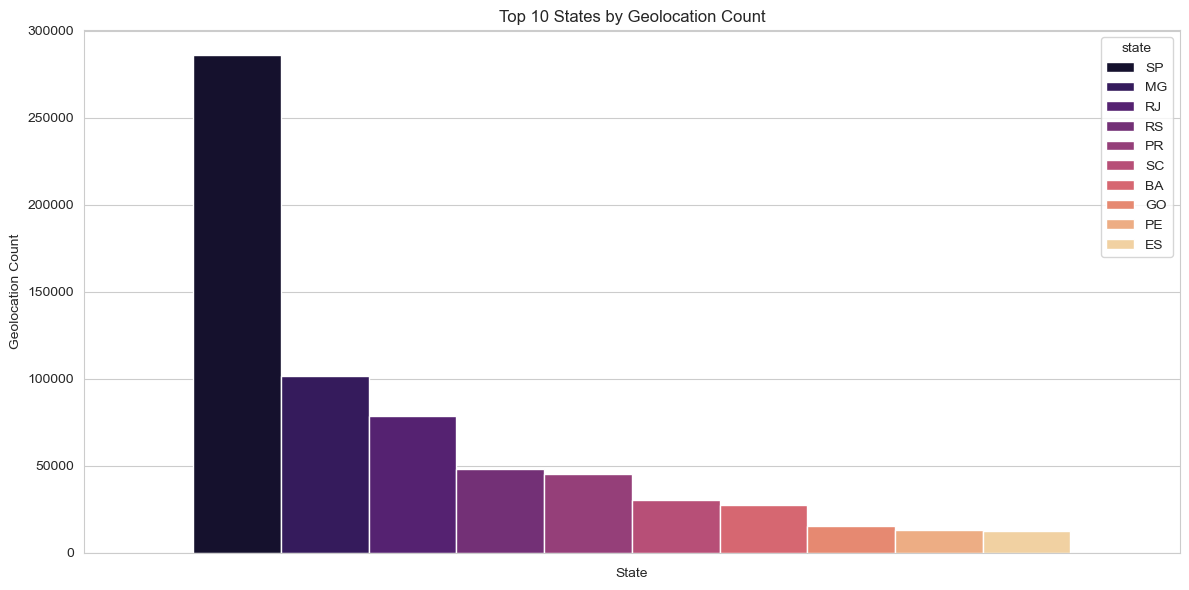

In [63]:
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(
    data=location_count_by_state.head(10),
    hue = 'state', y='counts',
    palette='magma'
)
plt.title("Top 10 States by Geolocation Count")
plt.xlabel("State")
plt.ylabel("Geolocation Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,zip_prefix,latitude,longitude,city,state,geometry
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.499273,-47.396658,franca,SP,POINT (-47.39666 -20.49927)
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790.0,-23.728396,-46.542250,sao bernardo do campo,SP,POINT (-46.54225 -23.7284)
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1151.0,-23.531309,-46.656690,sao paulo,SP,POINT (-46.65669 -23.53131)
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8775.0,-23.500670,-46.186348,mogi das cruzes,SP,POINT (-46.18635 -23.50067)
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,13056.0,-22.975708,-47.143140,campinas,SP,POINT (-47.14314 -22.97571)


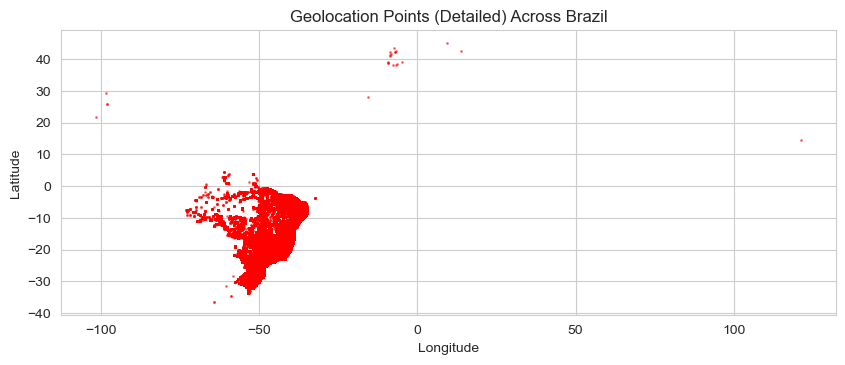

In [30]:
import matplotlib.pyplot as plt

# If you have a shapefile or GeoDataFrame for Brazil boundaries (e.g. 'brazil_states_gdf'), you can plot it:
# brazil_states_gdf.plot(color='white', edgecolor='black', figsize=(8,8))

# Plot the original detailed points (this might be quite dense)
fig, ax = plt.subplots(figsize=(10, 8))
geolocation_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5)

plt.title("Geolocation Points (Detailed) Across Brazil")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [34]:
import folium

# Approximate center of Brazil
m_center = [-14.2350, -51.9253]
m = folium.Map(location=m_center, zoom_start=4, tiles="OpenStreetMap")

# If too many points, can consider sampling
sample_points = geolocation_gdf.sample(n=2000, random_state=42)

for _, row in sample_points.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.4
    ).add_to(m)

m
